# streaming in langGraph

1. .stream and .astream methods - are sync and async methods for streaming back outputs from a graph run.
2. modes = "updates", "values"

In [1]:
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, add_messages, END, START
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List
from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [5]:
class State(TypedDict):
    messages:Annotated[List, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: State):
    return{
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tool_router(state:State):
    last_message = state["messages"][-1]
    # print("last_message: ",last_message)
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return "tool_node"
    else:
        return END

tool_node = ToolNode(tools)

subgraph = StateGraph(State)
subgraph.add_node("agent",agent)
subgraph.add_node("tool_node",tool_node)
subgraph.add_edge("tool_node","agent")
subgraph.add_conditional_edges("agent",tool_router)
subgraph.set_entry_point("agent")

search_app = subgraph.compile()

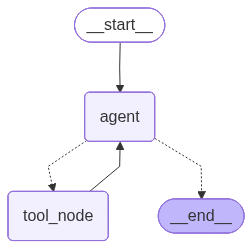

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [6]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}
events = search_app.stream(input=input, stream_mode="updates")
for event in events:
    print(event)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9cmn48kdm', 'function': {'arguments': '{"query":"Bangalore current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.034649306, 'prompt_time': 0.0193389, 'queue_time': 0.005146074, 'total_time': 0.053988206}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a333b148-23de-4d4c-a6f6-9196d085b40f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Bangalore current weather'}, 'id': '9cmn48kdm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307})]}}
{'tool_node': {'messages': [ToolMessage(content='[{"url": "https://www.weather25.com/asia/india/karnataka/bangalore?page=month&month=January", "content": "

In [8]:
input = {
    "messages": HumanMessage("Hi how are you?")
}

events = search_app.astream_events(input=input, version="v2")

async for event in events:
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': HumanMessage(content='Hi how are you?', additional_kwargs={}, response_metadata={})}}, 'name': 'LangGraph', 'tags': [], 'run_id': '2b083753-2829-45f1-ab4d-7d5d3b8fef15', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': HumanMessage(content='Hi how are you?', additional_kwargs={}, response_metadata={})}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '94e9affd-5cee-41f2-94b3-1081c415850c', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ('__start__',), 'langgraph_path': ('__pregel_pull', '__start__'), 'langgraph_checkpoint_ns': '__start__:3fc0ed12-375a-768b-fe44-ad881bfdac98'}, 'parent_ids': ['2b083753-2829-45f1-ab4d-7d5d3b8fef15']}
{'event': 'on_chain_start', 'data': {'input': {'messages': HumanMessage(content='Hi how are you?', additional_kwargs={}, response_metadata={})}}, 'name': '_write', 'tags': ['seq:step:1', 

In [9]:
input = {
    "messages": HumanMessage("Hi how are you?")
}

events = search_app.astream_events(input=input, version="v2")

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)
    

I'm functioning properly, thank you for asking. What can I help you with today?